In [1]:
%%capture
%pip install numpy pyfluids scipy matplotlib tqdm pandas

import numpy as np
from pyfluids import Fluid, FluidsList, Input
from scipy.optimize import minimize_scalar, shgo, dual_annealing, differential_evolution

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import multiprocessing
from tqdm import tqdm
import pandas as pd


In [2]:
GRAVITY = 9.81

In [3]:
c_ohh_two = Fluid(FluidsList.CarbonDioxide)

## Constants

In [4]:
dioxide_temps = np.array([10, 20])
dioxide_temps

array([10, 20])

In [5]:
dioxide_pressure = 6e6
dioxide_pressure

6000000.0

In [6]:
well_dists = np.array([70, 112])
well_dists

array([ 70, 112])

In [7]:
sequestration_rate = 3.24 # kg / s
sequestration_rate

3.24

In [8]:
well_depth = 3.2e3 # m

In [9]:
cold_well_temp = 2 # C

In [10]:
tube_diam = 2.375 * 0.0254
tube_thickness = 0.154 * 0.0254

casing_diam = 5.563 * 0.0254
casing_thickness = 0.258 * 0.0254

soil_effective_thickness = 2

tube_radii = [tube_diam / 2 - tube_thickness, tube_diam / 2, casing_diam / 2 - casing_thickness, casing_diam / 2, casing_diam / 2 + soil_effective_thickness]

carbon_steel_conductivity = 45 # W/mK
concrete_conductivity = 2.25 # W/mK
soil_conductivity = 1 # W/mK

tube_conductivities = [carbon_steel_conductivity, concrete_conductivity, carbon_steel_conductivity, soil_conductivity]

# Stuff To Check
* Make condenser outlet match the CO_2 Supply

## Vertical Pipe Slices

In [11]:
def radial_thermal_conduction(inner_radius, outer_radius, length, conductivity):
    return np.log(outer_radius / inner_radius) / (2 * np.pi * conductivity * length)

radial_thermal_conduction(0.1, 0.2, 1, 0.1)

1.103178000763258

In [12]:
def thermal_convection(mass_flow, fluid: Fluid, radius, length, heat_into_fluid):
    volumetric_flow = mass_flow / fluid.density
    velocity = volumetric_flow / (np.pi * radius ** 2)
    
    reynolds = 2 * radius * velocity / fluid.kinematic_viscosity

    if reynolds < 2300:
        nusselt = 3.66
    else:
        prandtl_exponent = 0.4 if heat_into_fluid else 0.3
        nusselt = 0.023 * reynolds ** 0.8 * fluid.prandtl ** prandtl_exponent
    
    h = nusselt * fluid.conductivity / (2 * radius)

    return 1 / (2 * np.pi * radius * length * h)



thermal_convection(1, c_ohh_two.with_state(
    Input.pressure(100e3), Input.temperature(-20)
), 0.1, 1, True)

0.03185715590417421

In [13]:
def friction_head_loss(mass_flow, fluid: Fluid, radius, length, relative_roughness=0.001):
    volumetric_flow = mass_flow / fluid.density
    velocity = volumetric_flow / (np.pi * radius ** 2)
    
    reynolds = 2 * radius * velocity / fluid.kinematic_viscosity

    if reynolds < 2300:
        friction_factor = 64 / reynolds
    else:
        # From https://github.com/MarkusPic/moody_chart/blob/master/moody_chart/moody_chart.py
        def _func(lambda_):
            return abs(1 / np.sqrt(lambda_) + 2 * np.log10(2.51 / (reynolds * np.sqrt(lambda_)) + 1 / 3.71 * relative_roughness))

        lambda_bounds = (0.01, 0.1)
        friction_factor = minimize_scalar(_func, method='bounded', bounds=lambda_bounds).x

    

    return friction_factor * length / (radius * 2) * velocity ** 2 / 2 / GRAVITY

friction_head_loss(1, c_ohh_two.with_state(
    Input.pressure(100e3), Input.temperature(-20)
), 0.1, 1)

1.174182632286475

In [14]:
def soil_temp(depth):
    return 10 + 62.5 / 1e3 * depth

soil_temp(3.2e3)

210.0

## Flow Through Formation

### Heat Transfer

In [15]:
A = 2
r = A ** 0.5 / np.pi
P = r * 2 * np.pi

def in_formation_heat_transfer(mass_flow, fluid: Fluid, well_to_well):
    well_temp = 220

    nusselt = 450

    h = nusselt * soil_conductivity / (2 * r)

    outlet_to_inlet_ratio = np.exp(-P * well_to_well * h / (mass_flow * fluid.specific_heat))

    return well_temp - (well_temp - fluid.temperature) * outlet_to_inlet_ratio

in_formation_heat_transfer(1, c_ohh_two.with_state(
    Input.pressure(100e3), Input.temperature(100)
), 140)

220.0

### Pressure Drop

In [16]:
def in_formation_pressure_drop(mass_flow, fluid: Fluid, well_to_well):
    volumetric_flow = mass_flow / fluid.density

    perm = 1e-12
    
    return volumetric_flow * fluid.dynamic_viscosity * well_to_well / A / perm

in_formation_pressure_drop(1, c_ohh_two.with_state(
    Input.pressure(100e3), Input.temperature(200)
), 140)

1425710213.3965037

## Condensor

In [17]:
def UA_from_cond_ops(inlet_fluid: Fluid, outlet_fluid: Fluid, cold_well_temp, mass_flow_rate):
    heat_transfer = mass_flow_rate * (inlet_fluid.enthalpy - outlet_fluid.enthalpy)

    log_mean_temp = inlet_fluid.temperature  - outlet_fluid.temperature
    log_mean_temp /= np.log((inlet_fluid.temperature - cold_well_temp) / (outlet_fluid.temperature - cold_well_temp))

    return heat_transfer / log_mean_temp

UA_from_cond_ops(c_ohh_two.with_state(
    Input.pressure(100e3), Input.temperature(200)
), c_ohh_two.with_state(
    Input.pressure(100e3), Input.temperature(20)
), 2, 1)

2219.6061458550016

## System Solving

## Overall State Variables when Optimizing

* Mass flow rate (possible two up values)
* Turbine Outlet Pressure
* Compressor Outlet Pressure
* Turbine & Compressor Efficiency

Fluid State Vector into each slice

constant mass flow rate down

* Enthalpy
  + Changes by Heat Transfer
    - Constant Soil Temp given the linear
    - slice of 2m of soil
    - cond through 3 pipe layer stackup
    - convective analysis with const Ts
  + Increases by frictional losses
  

* Pressure
  + Increase by rho g delta Z
  + Decrease by frictional losses

In [18]:
def SolveSlice(mass_flow, start_depth, end_depth, inlet_fluid: Fluid):
    thermal_network = []

    length = end_depth - start_depth

    avg_depth = (start_depth + end_depth) / 2

    inside_BC = inlet_fluid.temperature
    outside_BC = soil_temp(avg_depth)
    
    thermal_network.append(
      thermal_convection(mass_flow, inlet_fluid, tube_radii[0], length, inside_BC < outside_BC)
    )

    for ind, cond in enumerate(tube_conductivities):
      inner = tube_radii[ind]
      outer = tube_radii[ind + 1]

      thermal_network.append(
        radial_thermal_conduction(inner, outer, length, cond)
      )


    overall_resistance = sum(thermal_network)

    heat_transfer_in = (outside_BC - inside_BC) / overall_resistance

    frictional_head_loss = friction_head_loss(mass_flow, inlet_fluid, tube_radii[0], length)

    outlet_fluid = inlet_fluid.with_state(
      Input.internal_energy(inlet_fluid.internal_energy + heat_transfer_in / mass_flow + frictional_head_loss * GRAVITY),
      Input.pressure(inlet_fluid.pressure + inlet_fluid.density * GRAVITY * (length - frictional_head_loss))
    )

    return outlet_fluid

In [19]:
class SystemSolution:
  def __init__(self, flow_rates, turbine_outlet_pressure, compressor_outlet_pressure, turbine_efficiency, compressor_efficiency, supply_fluid: Fluid, VERTICAL_SLICES = 1000):

    downward_flow_rate = sum(flow_rates) + sequestration_rate

    post_comp_isen = supply_fluid.with_state(Input.pressure(compressor_outlet_pressure),
                                              Input.entropy(supply_fluid.entropy))

    post_compressor = supply_fluid.with_state(Input.pressure(compressor_outlet_pressure),
                                              Input.enthalpy(supply_fluid.enthalpy + compressor_efficiency * (post_comp_isen.enthalpy - supply_fluid.enthalpy)))
    
    output = post_compressor
    slice_log = []

    for slice in range(VERTICAL_SLICES):
      output = SolveSlice(downward_flow_rate,
                          slice / VERTICAL_SLICES * well_depth,
                          (slice + 1) / VERTICAL_SLICES * well_depth,
                          output)
      slice_log.append(output)
    
    pre_formation = output

    up_states = [pre_formation.with_state(Input.pressure(pre_formation.pressure - in_formation_pressure_drop(flow_rate, pre_formation, well_dist)),
                                          Input.temperature(in_formation_heat_transfer(flow_rate, pre_formation, well_dist))) for flow_rate, well_dist in zip(flow_rates, well_dists)]

    upward_logs = [[], []]

    pre_turbines = []

    for usi, up_state in enumerate(up_states):
      output = up_state
      for slice in range(VERTICAL_SLICES):
        output = SolveSlice(flow_rates[usi],
                              well_depth - slice / VERTICAL_SLICES * well_depth,
                              well_depth - (slice + 1) / VERTICAL_SLICES * well_depth,
                              output)
        upward_logs[usi].append(output)

      pre_turbines.append(output)

    post_turb_isens = [pre_turbine.with_state(Input.pressure(turbine_outlet_pressure),
                                              Input.entropy(pre_turbine.entropy)) for pre_turbine in pre_turbines]

    post_turbines = [pre_turbine.with_state(Input.pressure(turbine_outlet_pressure),
                                            Input.enthalpy(pre_turbine.enthalpy - turbine_efficiency * (pre_turbine.enthalpy - post_turb_isen.enthalpy))) for pre_turbine, post_turb_isen in zip(pre_turbines, post_turb_isens)]
    
    post_tee = supply_fluid.with_state(Input.pressure(turbine_outlet_pressure), Input.enthalpy(sum([post_turbine.enthalpy * flow_rate for post_turbine, flow_rate in zip(post_turbines, flow_rates)]) / sum(flow_rates)))

    self.condensorUA = UA_from_cond_ops(post_tee, supply_fluid, cold_well_temp, sum(flow_rates))

    self.turbine_production = sum([(pre_turbine.enthalpy - post_turbine.enthalpy) * flow_rate for pre_turbine, post_turbine, flow_rate in zip(pre_turbines, post_turbines, flow_rates)])
    self.compressor_consumption = (post_comp_isen.enthalpy - supply_fluid.enthalpy) * downward_flow_rate

  def __repr__(self):
    return f"Condensor UA:           {self.condensorUA:.5g} W/K\nTurbine Production:     {self.turbine_production:.5g} W\nCompressor Consumption: {self.compressor_consumption:.5g} W\nNet Power:              {self.turbine_production - self.compressor_consumption:.5g} W"

sol = SystemSolution( flow_rates=[2.852, 1.852],
                      turbine_outlet_pressure=dioxide_pressure,
                      compressor_outlet_pressure=120.000e+06,
                      turbine_efficiency=0.85,
                      compressor_efficiency=0.85,
                      supply_fluid=c_ohh_two.with_state(
                                          Input.pressure(dioxide_pressure),
                                          Input.temperature(dioxide_temps[0])
                                        ))
sol

Condensor UA:           30657 W/K
Turbine Production:     1.8396e+06 W
Compressor Consumption: 9.0752e+05 W
Net Power:              9.3211e+05 W

In [20]:
# Define the objective function
def objective_function(args):
  lfr, rfr, compressor_outlet_pressure = args
  try:
    sol = SystemSolution(flow_rates=[lfr, rfr],
              turbine_outlet_pressure=dioxide_pressure,
              compressor_outlet_pressure=compressor_outlet_pressure,
              turbine_efficiency=0.85,
              compressor_efficiency=0.85,
              supply_fluid=c_ohh_two.with_state(Input.pressure(dioxide_pressure),
                                                Input.temperature(dioxide_temps[0])))
    return sol.turbine_production - sol.compressor_consumption
  except Exception as e:
    return 0

objective_function((0.1, 0.1, 120.000e+06))

0

Using 80 processes


100%|██████████| 125000/125000 [54:52<00:00, 37.96it/s] 


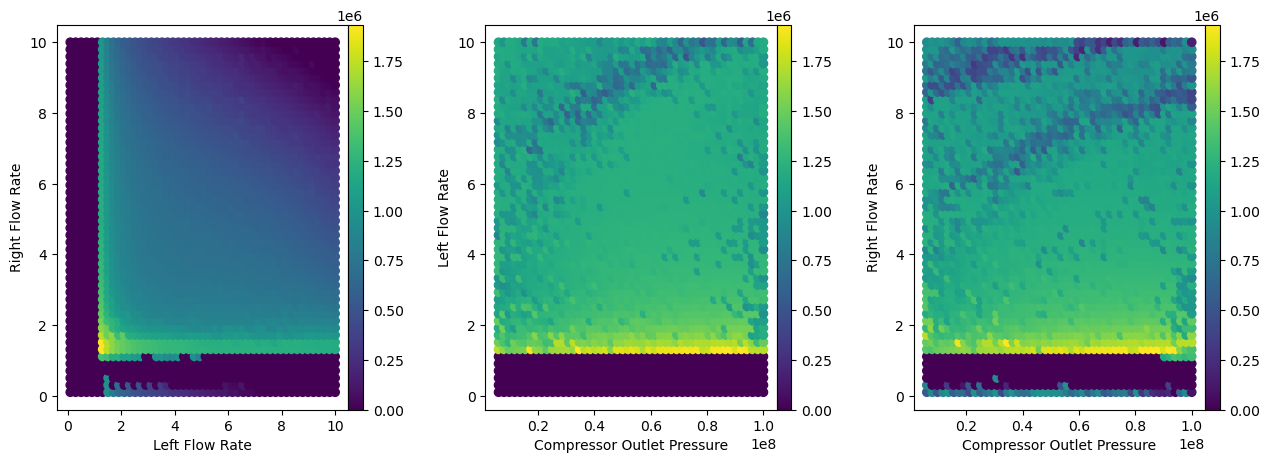

In [21]:
import warnings

warnings.filterwarnings('ignore')

N_FLOWS = 50
N_PRESS = 50

flow_range = np.linspace(0.1, 10, N_FLOWS)
press_range = np.linspace(dioxide_pressure, 100e6, N_PRESS)


# Create a list of parameter combinations
param_combinations = [(lfr, rfr, compressor_outlet_pressure)
            for lfr in flow_range
            for rfr in flow_range
            for compressor_outlet_pressure in press_range]

# Define the number of processes to use
num_processes = multiprocessing.cpu_count()

print(f"Using {num_processes} processes")

# objective_function(param_combinations[len(param_combinations) // 2])

# Create a multiprocessing pool
pool = multiprocessing.Pool(processes=num_processes)

# Apply the objective function to each parameter combination using multiprocessing
results = []
with tqdm(total=len(param_combinations)) as pbar:
  for result in pool.imap_unordered(objective_function, param_combinations):
    results.append(result)
    pbar.update(1)

# Close the multiprocessing pool
pool.close()

# Create a DataFrame from the results and param_combinations
first_column = [params[0] for params in param_combinations]
second_column = [params[1] for params in param_combinations]
third_column = [params[2] for params in param_combinations]

df = pd.DataFrame({'Left Flow Rate': first_column, 'Right Flow Rate': second_column, 'Compressor Outlet Pressure': third_column, 'Net Power': results})
df
# Create the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4)

ind = 0
for a in df.columns[:-1]:
  for b in df.columns[:-1]:
    if a != b and a < b:
      ax = axes[ind]

      # Plot the data in each subplot
      # Group the data by left and right flow rates and find the maximum net power
      max_net_power = df.groupby([a, b])['Net Power'].max()

      # Convert the grouped data into a DataFrame
      max_net_power_df = max_net_power.reset_index()
      im = ax.scatter(max_net_power_df[a], max_net_power_df[b], c=max_net_power_df['Net Power'], cmap='viridis')

      ax.set_xlabel(a)
      ax.set_ylabel(b)

      divider = make_axes_locatable(axes[ind])
      cax = divider.append_axes('right', size='5%', pad=0.0)
      fig.colorbar(im, cax=cax, orientation='vertical')
      
      ind += 1

plt.show()

In [27]:
bounds = [(0, 5), (0, 5), (dioxide_pressure, 400e6)]

def nobjective_function(args):
  return -objective_function(args)

shgo_sol = shgo(nobjective_function, bounds)

if shgo_sol.success:
  print(f"Left Flow Rate:  {shgo_sol.x[0]:.5g} (kg/s)\nRight Flow Rate: {shgo_sol.x[1]:.5g} (kg/s)\nCompressor Outlet Pressure: {shgo_sol.x[2]:.5g} Pa\nNet Power Production: {objective_function(shgo_sol.x):.5g} W")

Left Flow Rate:  1.6872 (kg/s)
Right Flow Rate: 1.6872 (kg/s)
Compressor Outlet Pressure: 2.03e+08 Pa
Net Power Production: 1.2062e+06 W
